<div style="font-size:30pt; line-height:25pt; font-weight:bold; text-align:center;">When, where and how to add new neurons to ANNs </div>

# Introduction

Neural networks have come a long way, especially deep models with lots of neurons. Most of these models have a fixed structure, meaning we decide on the number of neurons in each layer before training and then tweak the parameters based on the dataset.

However, there's a new approach in deep learning that's all about **dynamic networks**. Unlike the fixed ones, dynamic networks not only learn parameters during training but can also change their structure as they learn.

This shift to dynamic networks has some advantages. It makes training more efficient and eliminates the need for manual tweaking of architectures. Dynamic networks can adapt to new information and tasks easily. They can even add or remove parts like neurons and connections as needed.

This notebook is about understanding dynamic networks, focusing on a specific idea called **structural pruning**. This process involves selectively removing connections or neurons, showing a bit of a concept called neurogenesis. Neurogenesis is like adding new elements within existing layers. Structural pruning, as you'll see in this notebook, is an example that highlights how dynamic networks can keep evolving and improving.

# Artificial Neural Networks (ANNs)

First, let's make a short reminder about Artificial Neural Networks.

Artificial Neural Networks (ANNs) represent a class of computational models inspired by the neural architecture of the human brain. Operating as interconnected nodes organized into layers, ANNs leverage a combination of linear and non-linear transformations to capture complex relationships within data.

At their core, ANNs consist of an input layer, one or more hidden layers, and an output layer. Each connection between nodes is associated with a weight, and the network learns by adjusting these weights during a training phase. The training process involves minimizing a predefined loss function, typically through optimization algorithms like stochastic gradient descent (SGD).

Activation functions introduce non-linearities into the network, enabling the modeling of intricate mappings between inputs and outputs. Common activation functions include Rectified Linear Units (ReLU), Sigmoid, and Hyperbolic Tangent (tanh), each influencing the network's capacity to capture and propagate information through the layers..

Training large-scale ANNs requires careful consideration of hyperparameters, such as learning rates, batch sizes, and regularization techniques to prevent overfitting.

You can find more information and detail on **[this github](https://github.com/SupaeroDataScience/deep-learning)**

<center><img src="img\ann.png" width="600px"></img></center>

## Time to code !! ##

Let's make a little ANN to classify the **[MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database)**. The MNIST dataset is composed of a collection of handwritten digit images, MNIST stands as a foundational resource for training and evaluating algorithms designed to recognize and classify digits from 0 to 9.
Each image in the MNIST dataset is a grayscale, 28x28-pixel representation of a handwritten digit.

**We will use Pytorch but you can do the same thing with Keras**

First, let's load the data and print 9 random figures :

In [1]:
# Import the necessary libraries

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim


In [2]:
# We need a, image transform to convert to Tensor and normalize with a mean of 0.5 and standard deviation of 0.5
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

# Download the Train and Test set

trainset = datasets.MNIST('.', train=True, download=True, transform=transform)
testset = datasets.MNIST('.', train=False, download=True, transform=transform)

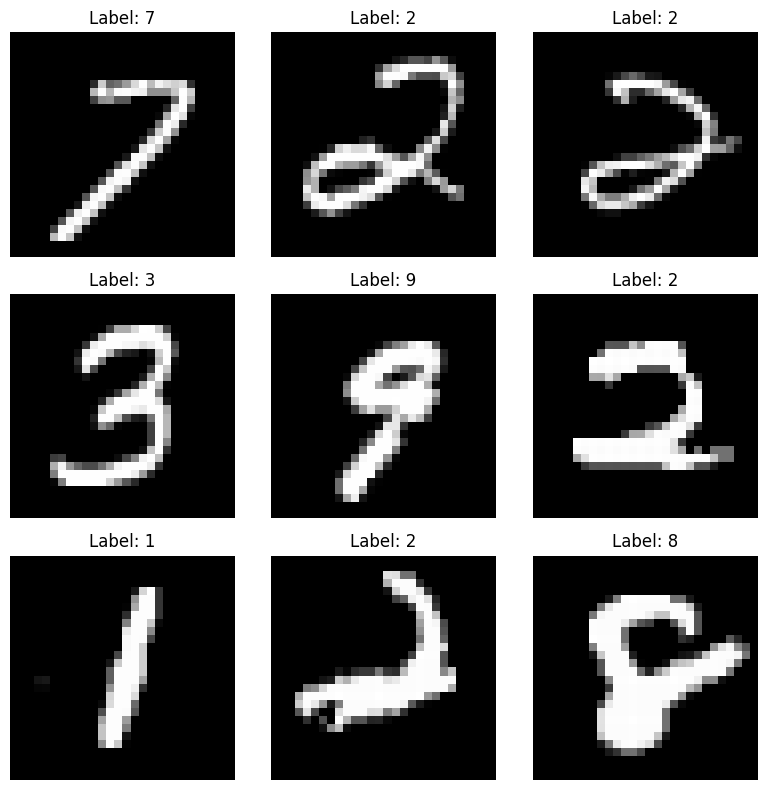

In [3]:
# Set up a 3x3 grid for displaying the images
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()

# Get 9 random indices from the training set
random_indices = np.random.choice(len(trainset), size=9, replace=False)

# Display the 9 random images
for i, idx in enumerate(random_indices):
    image, label = trainset[idx]
    image = image.numpy().squeeze()
    
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Parameters for the dataloader
batch_size = 64
valid_size = 0.2
nb_epochs = 10
lr = 0.001

In [5]:
# Split the training set into training and validation sets
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define the samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [6]:
# Create the dataloaders
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)

Now that we have prepared the data, we can implement a little ANN, with 2 hidden layers to classify the figures.

In [7]:
# Model architecture of the neural network fully connected

class ANN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_1, hidden_layer_2):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_layer_1), 
            nn.ReLU(),
            nn.Linear(hidden_layer_1, hidden_layer_2),
            nn.ReLU(),
            nn.Linear(hidden_layer_2, output_size),
            nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.network(x)

# Create the model
input_size = 28*28
output_size = 10
hidden_layer_1 = 512
hidden_layer_2 = 512

model = ANN(input_size, output_size, hidden_layer_1, hidden_layer_2)

# Define the loss function and the optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
print(model)

ANN(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)


In [10]:
# Train the model
list_loss = []
for i in tqdm(range(nb_epochs),desc="Training of the ANN"):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # print(loss)
    list_loss.append(running_loss/len(train_loader))
    
    print(f"Epoch nb {i+1}. Training loss: {running_loss/len(train_loader)}")

Epoch nb 1. Training loss: 0.1355456942965587
Epoch nb 2. Training loss: 0.10274540358409286
Epoch nb 3. Training loss: 0.08436072344519198
Epoch nb 4. Training loss: 0.06993393367156386
Epoch nb 5. Training loss: 0.06602955998837327
Epoch nb 6. Training loss: 0.050399908419543255
Epoch nb 7. Training loss: 0.05046338582768416
Epoch nb 8. Training loss: 0.043288744537703074
Epoch nb 9. Training loss: 0.039324016865692105
Epoch nb 10. Training loss: 0.03611926814343314


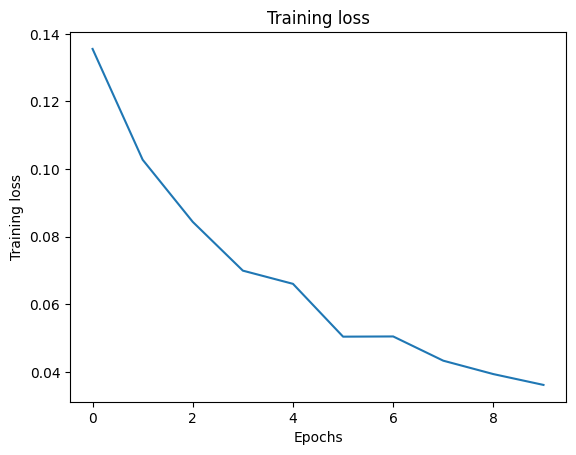

In [11]:
# Plot the training loss
plt.plot(list_loss)
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Training loss')
plt.show()

In [16]:
# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in valid_loader:
        output = model(images)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the validation set: {100 * correct / total:.2f}%")


Accuracy of the model on the validation set: 97.21%


# Structural pruning 


<center><img src="img\Pruning image.webp" width="500px"></img></center>